In [10]:
from SALA import processing
from SALA import plots
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [2]:
all_quarters_activity = pd.read_parquet('data/seattle_undergrad/all_quarters_activity.parquet')
all_quarters_activity

,UID,Date,GroupDayType,Sleep onset,Sleep offset,Sleep duration,Sleep onset MSLM,Sleep offset MSLM,Activity,bedtime,standarized_bedtime,sleep_duration_zscore,bedtime_zscore
0,summer_160048,2016-07-13,summer_16Weekday,2016-07-14 02:46:30,2016-07-14 08:49:15,6.045833,1606.50,529.25,-0.801863,2.766667,6.150000,-0.743735,0.311579
1,summer_160048,2016-07-14,summer_16Weekday,2016-07-15 02:25:00,2016-07-15 12:27:30,10.041667,1585.00,747.50,-0.395109,2.416667,5.800000,1.233268,0.067151
2,summer_160048,2016-07-15,summer_16Weekday,2016-07-16 01:42:00,2016-07-16 09:03:00,7.350000,1542.00,543.00,1.536863,1.700000,5.083333,-0.098477,-0.433345
3,summer_160048,2016-07-16,summer_16Weekend/Holiday,2016-07-17 04:45:30,2016-07-17 13:34:30,8.816667,1725.50,814.50,1.318894,4.750000,8.133333,0.627179,1.696671
4,summer_160048,2016-07-17,summer_16Weekend/Holiday,2016-07-18 01:31:15,2016-07-18 12:23:00,10.862500,1531.25,743.00,1.344529,1.516667,4.900000,1.639388,-0.561379
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6373,fall_160030,2016-11-07,fall_16Weekday,2016-11-08 02:02:45,2016-11-08 07:33:45,5.516667,1562.75,453.75,-0.228010,2.033333,8.033333,-1.069753,0.058225
6374,fall_160030,2016-11-08,fall_16Weekday,2016-11-09 02:09:00,2016-11-09 09:22:30,7.225000,1569.00,562.50,-0.610670,2.150000,8.150000,-0.204512,0.134213
6375,fall_160030,2016-11-09,fall_16Weekday,2016-11-10 02:43:15,2016-11-10 11:28:30,8.754167,1603.25,688.50,0.915694,2.716667,8.716667,0.569985,0.503297
6376,fall_160030,2016-11-12,fall_16Weekend/Holiday,2016-11-13 03:43:45,2016-11-13 12:45:45,9.033333,1663.75,765.75,-0.322485,3.716667,9.716667,0.711378,1.154623


In [4]:
len(all_quarters_activity.UID.unique())

508

6378 student days, 508 students, on average each student wears the watch for 12.55 days.

In [20]:
def groupDayTypeToWeekendBoolean(groupDayType):
    if groupDayType.split("W")[1] == 'eekday':
        return True
    elif groupDayType.split("W")[1] == 'eekend/Holiday':
        return False
    else:
        return "something went wrong in groupDayTypeToWeekendBoolean"

In [21]:
all_quarters_activity['isWeekday'] = all_quarters_activity['GroupDayType'].apply(groupDayTypeToWeekendBoolean)

In [68]:
fall_processed = pd.read_parquet('data/seattle_undergrad/processed/all_falltiming.parquet')
fall_processed

,UID,Date,Threshold,Last Light,Mins to LL from 4AM,First Light,Mins to FL from 4AM,Time above threshold,Time above threshold AM,Minutes above threshold,...,GroupDayofWeek,GroupDayType,Weekend/Holiday,Sunrise,Sunset,Sleep onset,Sleep offset,Sleep duration,Sleep onset MSLM,Sleep offset MSLM
index,,,,,,,,,,,,,,,,,,,,,
0,fall_150034,2015-10-16,5,2015-10-17 00:12:00,1212.0,2015-10-16 06:21:15,141.0,0 days 07:10:00,0 days 01:56:00,430.00,...,fall_15Fri,fall_15Weekday,False,2015-10-16 07:25:12.688462+01:00,2015-10-16 18:05:11.239169+01:00,2015-10-17 00:56:15,2015-10-17 05:36:30,0 days 04:40:15,1496.25,336.50
1,fall_150034,2015-10-17,5,2015-10-18 03:23:15,1403.0,2015-10-17 08:11:45,251.0,0 days 06:43:45,0 days 02:08:45,403.75,...,fall_15Sat,fall_15Weekend/Holiday,True,2015-10-17 07:26:54.874139+01:00,2015-10-17 18:03:03.941839+01:00,2015-10-18 03:41:15,2015-10-18 07:44:00,0 days 04:02:45,1661.25,464.00
2,fall_150034,2015-10-15,5,2015-10-15 22:58:15,1138.0,2015-10-15 06:16:15,136.0,0 days 07:15:30,0 days 02:21:30,435.50,...,fall_15Thu,fall_15Weekday,False,2015-10-15 07:23:30.812126+01:00,2015-10-15 18:07:19.387314+01:00,2015-10-16 00:07:00,2015-10-16 04:41:30,0 days 04:34:30,1447.00,281.50
3,fall_150034,2015-10-18,5,2015-10-19 00:08:45,1208.0,2015-10-18 08:36:15,276.0,0 days 02:50:30,0 days 00:57:30,170.50,...,fall_15Sun,fall_15Weekend/Holiday,True,2015-10-18 07:28:37.367299+01:00,2015-10-18 18:00:57.533975+01:00,2015-10-19 00:55:30,2015-10-19 05:05:30,0 days 04:10:00,1495.50,305.50
4,fall_150034,2015-10-09,5,2015-10-10 00:26:15,1226.0,2015-10-09 06:06:45,126.0,0 days 06:47:00,0 days 02:24:45,407.00,...,fall_15Fri,fall_15Weekday,False,2015-10-09 07:13:26.008528+01:00,2015-10-09 18:20:24.052274+01:00,2015-10-10 01:06:15,2015-10-10 06:43:30,0 days 05:37:15,1506.25,403.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2091,fall_160030,2016-11-06,500,2016-11-07 00:05:15,1205.0,2016-11-06 11:25:45,445.0,0 days 00:35:45,0 days 00:00:30,35.75,...,fall_16Sun,fall_16Weekend/Holiday,True,2016-11-06 07:03:09.290174+00:00,2016-11-06 16:23:25.384252+00:00,2016-11-07 02:22:30,2016-11-07 07:52:00,0 days 05:29:30,1582.50,472.00
2092,fall_160030,2016-11-14,500,2016-11-14 22:44:00,1124.0,2016-11-14 08:30:00,270.0,0 days 04:30:15,0 days 01:38:00,270.25,...,fall_16Mon,fall_16Weekday,False,2016-11-14 07:17:06.993865+00:00,2016-11-14 16:11:16.336204+00:00,2016-11-15 03:09:15,2016-11-15 12:17:45,0 days 09:08:30,1629.25,737.75
2093,fall_160030,2016-11-13,500,2016-11-13 22:32:45,1112.0,2016-11-13 13:35:00,575.0,0 days 00:48:15,0 days 00:00:00,48.25,...,fall_16Sun,fall_16Weekend/Holiday,True,2016-11-13 07:15:23.596621+00:00,2016-11-13 16:12:40.100705+00:00,2016-11-14 04:23:00,2016-11-14 07:59:00,0 days 03:36:00,1703.00,479.00


In [69]:
winter_processed = pd.read_parquet('data/seattle_undergrad/processed/all_wintertiming.parquet')
winter_processed

,UID,Date,Threshold,Last Light,Mins to LL from 4AM,First Light,Mins to FL from 4AM,Time above threshold,Time above threshold AM,Minutes above threshold,...,GroupDayofWeek,GroupDayType,Weekend/Holiday,Sunrise,Sunset,Sleep onset,Sleep offset,Sleep duration,Sleep onset MSLM,Sleep offset MSLM
index,,,,,,,,,,,,,,,,,,,,,
0,winter0112,2018-02-16,5,2018-02-17 03:07:45,1387.0,2018-02-16 13:46:30,586.0,0 days 01:21:15,0 days 00:00:00,81.25,...,winterFri,winterWeekday,False,2018-02-16 07:12:22.965821+00:00,2018-02-16 17:16:32.500559+00:00,2018-02-17 03:43:00,2018-02-17 12:41:15,0 days 08:58:15,1663.00,761.25
1,winter0112,2018-02-13,5,2018-02-14 01:29:00,1289.0,2018-02-13 11:05:15,425.0,0 days 02:15:00,0 days 00:02:45,135.00,...,winterTues,winterWeekday,False,2018-02-13 07:18:05.948565+00:00,2018-02-13 17:11:04.216088+00:00,2018-02-14 02:10:00,2018-02-14 07:23:45,0 days 05:13:45,1570.00,443.75
2,winter0112,2018-02-21,5,2018-02-22 01:51:15,1311.0,2018-02-21 11:10:00,430.0,0 days 02:19:00,0 days 00:26:00,139.00,...,winterWed,winterWeekday,False,2018-02-21 07:02:26.797121+00:00,2018-02-21 17:25:35.733208+00:00,2018-02-22 02:25:15,2018-02-22 10:29:30,0 days 08:04:15,1585.25,629.50
3,winter0112,2018-02-20,5,2018-02-21 01:19:30,1279.0,2018-02-20 14:08:45,608.0,0 days 05:03:15,0 days 00:00:00,303.25,...,winterTues,winterWeekday,False,2018-02-20 07:04:28.279350+00:00,2018-02-20 17:23:47.550573+00:00,2018-02-21 04:37:45,2018-02-21 10:59:15,0 days 06:21:30,1717.75,659.25
4,winter0112,2018-02-09,5,2018-02-10 02:05:30,1325.0,2018-02-09 11:06:15,426.0,0 days 03:52:30,0 days 00:16:45,232.50,...,winterFri,winterWeekday,False,2018-02-09 07:25:23.531289+00:00,2018-02-09 17:03:44.946935+00:00,2018-02-10 03:46:30,2018-02-10 12:44:30,0 days 08:58:00,1666.50,764.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1386,winter0041,2018-02-04,500,2018-02-04 23:37:15,1177.0,2018-02-04 08:14:30,254.0,0 days 02:40:00,0 days 00:50:00,160.00,...,winterSun,winterWeekend/Holiday,True,2018-02-04 07:33:54.448566+00:00,2018-02-04 16:54:36.077024+00:00,2018-02-05 01:26:45,2018-02-05 08:41:15,0 days 07:14:30,1526.75,521.25
1387,winter0041,2018-02-03,500,2018-02-03 22:36:30,1116.0,2018-02-03 16:33:15,753.0,0 days 00:32:30,0 days 00:00:00,32.50,...,winterSat,winterWeekend/Holiday,True,2018-02-03 07:35:31.319807+00:00,2018-02-03 16:52:46.709692+00:00,2018-02-04 02:13:15,2018-02-04 07:22:45,0 days 05:09:30,1573.25,442.75
1388,winter0041,2018-01-27,500,2018-01-28 02:03:00,1323.0,2018-01-27 15:50:45,710.0,0 days 00:24:30,0 days 00:00:00,24.50,...,winterSat,winterWeekend/Holiday,True,2018-01-27 07:45:53.448802+00:00,2018-01-27 16:40:10.781421+00:00,2018-01-28 02:58:45,2018-01-28 11:22:00,0 days 08:23:15,1618.75,682.00


In [22]:
all_quarters_activity

,UID,Date,GroupDayType,Sleep onset,Sleep offset,Sleep duration,Sleep onset MSLM,Sleep offset MSLM,Activity,bedtime,standarized_bedtime,sleep_duration_zscore,bedtime_zscore,isWeekday
0,summer_160048,2016-07-13,summer_16Weekday,2016-07-14 02:46:30,2016-07-14 08:49:15,6.045833,1606.50,529.25,-0.801863,2.766667,6.150000,-0.743735,0.311579,True
1,summer_160048,2016-07-14,summer_16Weekday,2016-07-15 02:25:00,2016-07-15 12:27:30,10.041667,1585.00,747.50,-0.395109,2.416667,5.800000,1.233268,0.067151,True
2,summer_160048,2016-07-15,summer_16Weekday,2016-07-16 01:42:00,2016-07-16 09:03:00,7.350000,1542.00,543.00,1.536863,1.700000,5.083333,-0.098477,-0.433345,True
3,summer_160048,2016-07-16,summer_16Weekend/Holiday,2016-07-17 04:45:30,2016-07-17 13:34:30,8.816667,1725.50,814.50,1.318894,4.750000,8.133333,0.627179,1.696671,False
4,summer_160048,2016-07-17,summer_16Weekend/Holiday,2016-07-18 01:31:15,2016-07-18 12:23:00,10.862500,1531.25,743.00,1.344529,1.516667,4.900000,1.639388,-0.561379,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6373,fall_160030,2016-11-07,fall_16Weekday,2016-11-08 02:02:45,2016-11-08 07:33:45,5.516667,1562.75,453.75,-0.228010,2.033333,8.033333,-1.069753,0.058225,True
6374,fall_160030,2016-11-08,fall_16Weekday,2016-11-09 02:09:00,2016-11-09 09:22:30,7.225000,1569.00,562.50,-0.610670,2.150000,8.150000,-0.204512,0.134213,True
6375,fall_160030,2016-11-09,fall_16Weekday,2016-11-10 02:43:15,2016-11-10 11:28:30,8.754167,1603.25,688.50,0.915694,2.716667,8.716667,0.569985,0.503297,True
6376,fall_160030,2016-11-12,fall_16Weekend/Holiday,2016-11-13 03:43:45,2016-11-13 12:45:45,9.033333,1663.75,765.75,-0.322485,3.716667,9.716667,0.711378,1.154623,False


In [28]:
weekdays_df = all_quarters_activity[all_quarters_activity['isWeekday']==True]
weekends_df = all_quarters_activity[all_quarters_activity['isWeekday']==False]

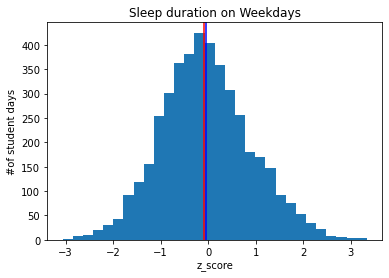

In [65]:
#Sleep duration on Weekdays
plt.hist(weekdays_df['sleep_duration_zscore'], bins=30)
plt.axvline(x = weekdays_df['sleep_duration_zscore'].mean(), color = 'b', label = 'mean')
plt.axvline(x = weekdays_df['sleep_duration_zscore'].median(), color = 'r', label = 'median')
plt.xlabel('z_score')
plt.ylabel('#of student days')
plt.title('Sleep duration on Weekdays')
plt.show()

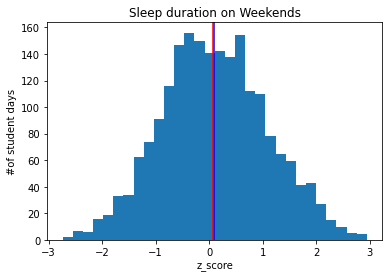

In [64]:
#Sleep duration on Weekends
plt.hist(weekends_df['sleep_duration_zscore'], bins=30)
plt.axvline(x = weekends_df['sleep_duration_zscore'].mean(), color = 'b', label = 'mean')
plt.axvline(x = weekends_df['sleep_duration_zscore'].median(), color = 'r', label = 'median')
plt.xlabel('z_score')
plt.ylabel('#of student days')
plt.title('Sleep duration on Weekends')
plt.show()

- There's no extreme outliers for sleep duration on weekends (above 3 or below -3)
- Sleep duration on weekdays is centered at almost 0. Slightly left of 0
- Sleep duration on weekends is centered at almost 0. Slightly right of 0
- People sleep at more random times on weekends since center is wider
- People are sleeping for less random intervals of time

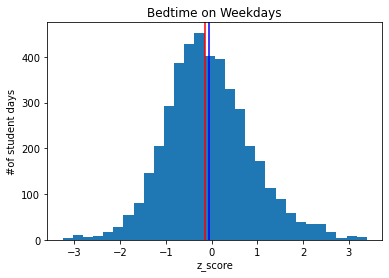

In [61]:
#Bedtime on Weekdays
plt.hist(weekdays_df['bedtime_zscore'], bins=30)
plt.axvline(x = weekdays_df['bedtime_zscore'].mean(), color = 'b', label = 'mean')
plt.axvline(x = weekdays_df['bedtime_zscore'].median(), color = 'r', label = 'median')
plt.xlabel('z_score')
plt.ylabel('#of student days')
plt.title('Bedtime on Weekdays')
plt.show()

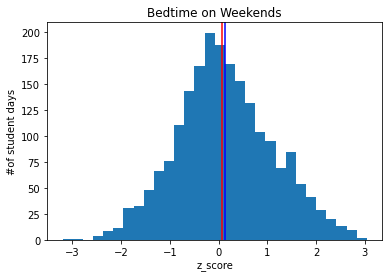

In [66]:
#Bedtime on Weekends
plt.hist(weekends_df['bedtime_zscore'], bins=30)
plt.axvline(x = weekends_df['bedtime_zscore'].mean(), color = 'b', label = 'mean')
plt.axvline(x = weekends_df['bedtime_zscore'].median(), color = 'r', label = 'median')
plt.xlabel('z_score')
plt.ylabel('#of student days')
plt.title('Bedtime on Weekends')
plt.show()

- Bedtime on weekdays is skewed right
- Bedtime on weekends is shifted right from bedtime on weekdays